# DRL Crypto Portfolio 

This project demonstrates the use of deep reinforcement learning (PPO) for adaptive crypto portfolio optimization using a custom Gymnasium environment. The approach balances between maximizing returns and managing risk via a differential Sharpe reward function. 

📚 **Reference**  
> This implementation is inspired by the differential Sharpe optimization method proposed in:  
>
> Srijan Sood, Kassiani Papasotiriou, Marius Vaiciulis, and Tucker Balch. (2023).
> *Deep Reinforcement Learning for Optimal Portfolio Allocation: A Comparative Study with Mean-Variance Optimization*.
> In Proceedings of the ICAPS 2023 Workshop on AI in Finance (FinPlan).
> [PDF](https://icaps23.icaps-conference.org/papers/finplan/FinPlan23_paper_4.pdf)
>
> In this work, the reward is based on the differential form of the Sharpe ratio, allowing the agent to optimize risk-adjusted returns incrementally at each timestep.

In [1]:
# Import required libraries and custom modules.
# The custom environment (PortfolioEnv) simulates portfolio returns over time using price and volatility inputs.
# Stable-Baselines3 PPO is used as the RL agent.
# Evaluation and feature engineering utilities are modularized in the `drl_portfolio` package.

# === Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

import sys
sys.path.append("..")  # current directory

from drl_portfolio.env import PortfolioEnv
from drl_portfolio.features import generate_features
from drl_portfolio.utils import generate_time_windows

## 1. Download and save the crypto data from Binance

- The price dataframe contains 4-hour interval OHLC data for multiple crypto assets.

In [2]:
cryp_data_downloaded = True # Set to False if you want to Download from Binance

In [3]:
if not cryp_data_downloaded:
    from binance.client import Client
    from datetime import datetime, timedelta
    import time

    # No need for API keys for public data
    client = Client(tld='US')

    def get_binance_ohlcv(symbol: str, interval: str = '1d', start: str = '1 Jan 2020'):
        """
        Get historical OHLCV data from Binance for a given symbol.
        """
        bars = client.get_historical_klines(symbol, interval, start)
        df = pd.DataFrame(bars, columns=[
            'open_time', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'number_of_trades',
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ])
        df['date'] = pd.to_datetime(df['open_time'], unit='ms')
        df.set_index('date', inplace=True)
        df = df[['close']].astype(float)
        return df

    # Choose symbols (must be valid Binance trading pairs)
    symbols = symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LTCUSDT', 'ADAUSDT', 'NEOUSDT', 'XLMUSDT']
    start_date = '2020-01-01'
    dfs = []

    freq='4h'

    for symbol in symbols:
        df = get_binance_ohlcv(symbol, interval=freq, start=start_date)
        df.rename(columns={'close': symbol}, inplace=True)
        dfs.append(df)
        time.sleep(0.5)  # Be gentle with the API

    # Merge into single DataFrame
    price_df = pd.concat(dfs, axis=1)
    price_df.to_csv("../data/crypto_data.csv")

else:
    price_df = pd.read_csv("../data/crypto_data.csv", index_col="date", parse_dates=True)

In [4]:
price_df.head(5)

,BTCUSDT,ETHUSDT,BNBUSDT,LTCUSDT,ADAUSDT,NEOUSDT,XLMUSDT
date,,,,,,,
2020-01-01 00:00:00,7230.71,130.18,13.8159,41.58,0.03308,8.736,0.04515
2020-01-01 04:00:00,7205.50,130.52,13.7648,41.55,0.03320,8.716,0.04493
2020-01-01 08:00:00,7195.80,130.84,13.7162,41.67,0.03321,8.791,0.04509
2020-01-01 12:00:00,7233.02,131.84,13.7958,41.89,0.03357,8.905,0.04542
2020-01-01 16:00:00,7223.72,131.98,13.7270,41.79,0.03361,8.940,0.04547


## 2. PPO trainining

In this section, we train a PPO agent from scratch using a sliding window of historical data.
Each window defines a training and test period. The model is trained using the `PortfolioEnv`, which outputs a Sharpe-related reward signal at each timestep.
Training can take several million timesteps depending on the environment length and frequency.

Generate time windows for train, validation, test set. 

In [5]:
windows = generate_time_windows(price_df, train_years=3.5, test_years=0.5)
for i, w in enumerate(windows):
    print(f"Window {i+1}: Train {w[0]}–{w[1]}, Test {w[2]}–{w[3]}")

Window 1: Train 2020-01-01–2023-07-01, Test 2023-07-02–2023-12-30
Window 2: Train 2020-07-01–2023-12-30, Test 2023-12-31–2024-06-29
Window 3: Train 2020-12-30–2024-06-29, Test 2024-06-30–2024-12-28


Check any invalid values from the price data

In [6]:
for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
    print(f"\n🔍 Window {i+1}: {train_start} to {test_end}")

    # Extract full range (train + val + test)
    window_df = price_df.loc[train_start:test_end]

    # Check per asset
    for symbol in price_df.columns:
        num_nans = window_df[symbol].isna().sum()
        if num_nans > 0:
            print(f"⚠️ {symbol} has {num_nans} missing values in this window")


🔍 Window 1: 2020-01-01 to 2023-12-30

🔍 Window 2: 2020-07-01 to 2024-06-29

🔍 Window 3: 2020-12-30 to 2024-12-28


In [7]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
import numpy as np
import matplotlib.pyplot as plt

results = []

lookback_long = 60
lookback_short = 20

lookbacks=(lookback_short, lookback_long)

use_saved_models = True

# Training happens on a custom vectorized environment across multiple processes.
# PPO is configured with clipped objective and uses GAE for advantage estimation.
# The model is logged to TensorBoard for reward tracking and saved to disk after training.
if not use_saved_models:
    for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
        print(f"\n🌀 Window {i+1}:")
        print(f"Train: {train_start} to {train_end}")
        print(f"Test : {test_start} to {test_end}")

        # === Slice data ===
        df_train = price_df.loc[train_start:train_end]
        df_test = price_df.loc[test_start:test_end]

        # === Features ===
        log_returns_tv, vol_feats_tv, prices_tv = generate_features(df_train, lookbacks=lookbacks)
        log_returns_test, vol_feats_test, prices_test = generate_features(df_test, lookbacks=lookbacks)

        # === Training env (parallelized) ===
        def make_env(i):
            def _init():
                return PortfolioEnv(data=prices_tv, vol_features=vol_feats_tv)
            return _init

        vec_env = SubprocVecEnv([make_env(i) for i in range(4)])

        # === PPO model ===
        model = PPO(
            "MlpPolicy",
            vec_env,
            learning_rate=3e-4,
            n_steps=2048,
            batch_size=4096,
            n_epochs=10,
            gamma=0.9,
            gae_lambda=0.9,
            clip_range=0.25,
            policy_kwargs=dict(net_arch=[64, 64]),
            verbose=1,
            tensorboard_log="../results/ppo_logs/"
        )

        print("🔧 Training...")
        model.learn(total_timesteps=8_000_000, tb_log_name=f"PPO_crypto_window_{i+1}", log_interval=10)
        vec_env.close()

        # === Backtesting ===
        print("🧪 Backtesting...")
        test_env = PortfolioEnv(data=prices_test, vol_features=vol_feats_test)
        obs, _ = test_env.reset()
        done = False
        portfolio_vals = [test_env.portfolio_value]
        weights_log = []

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            weights = np.exp(action) / np.sum(np.exp(action))
            weights_log.append(weights)

            obs, _, done, _, _ = test_env.step(action)
            portfolio_vals.append(test_env.portfolio_value)

        results.append({
            "window": i + 1,
            "portfolio_values": portfolio_vals,
            "weights": np.array(weights_log),
            "start_date": test_start,
            "end_date": test_end,
            "dates": log_returns_test.index[lookbacks[1]:]  # ✅ add this line

        })

        #print(len(portfolio_vals), len(log_returns_test))
        print(f"✅ Final portfolio value: {portfolio_vals[-1]:.2f}")
        model.save(f"../results/models/ppo_window_{i+1}_8M")


# Alternatively, you can skip training and load a pre-trained PPO model saved in the previous step.
else:
    for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
        print(f"\n📦 Loading PPO model for Window {i+1}")
        model = PPO.load(f"../results/models/ppo_window_{i+1}_8M")

        # === Slice test data ===
        df_test = price_df.loc[test_start:test_end]

        # === Features ===
        log_returns_test, vol_feats_test, prices_test = generate_features(df_test, lookbacks=lookbacks)

        # === Backtesting ===
        print("🧪 Backtesting...")
        test_env = PortfolioEnv(data=prices_test, vol_features=vol_feats_test)
        obs, _ = test_env.reset()
        done = False
        portfolio_vals = [test_env.portfolio_value]
        weights_log = []

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            weights = np.exp(action) / np.sum(np.exp(action))
            weights_log.append(weights)

            obs, _, done, _, _ = test_env.step(action)
            portfolio_vals.append(test_env.portfolio_value)

        results.append({
            "window": i + 1,
            "portfolio_values": portfolio_vals,
            "weights": np.array(weights_log),
            "start_date": test_start,
            "end_date": test_end,
            "dates": log_returns_test.index[lookbacks[1]:]
        })

        print(f"✅ Final portfolio value: {portfolio_vals[-1]:.2f}")    


📦 Loading PPO model for Window 1
🧪 Backtesting...
✅ Final portfolio value: 1.51

📦 Loading PPO model for Window 2
🧪 Backtesting...
✅ Final portfolio value: 1.54

📦 Loading PPO model for Window 3
🧪 Backtesting...
✅ Final portfolio value: 2.14


## 3. Add baseline models

### 3.1. Mean Variance optimization

In [8]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

def get_mvo_weights(price_df_window):
    """
    Compute mean-variance optimized portfolio weights using PyPortfolioOpt.
    No shorting allowed, full investment.
    """
    # Expected returns and covariance
    mu = mean_historical_return(price_df_window, frequency=6*365)  # 6 per day for 4H
    S = CovarianceShrinkage(price_df_window).ledoit_wolf()

    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    return np.array([cleaned_weights.get(sym, 0.0) for sym in price_df_window.columns])

In [9]:
def simulate_mvo_portfolio(price_df, weights):
    """
    Simulate portfolio value over time using fixed weights.
    """
    norm_prices = price_df / price_df.iloc[0]
    weighted_prices = norm_prices * weights
    portfolio_value = weighted_prices.sum(axis=1)
    return portfolio_value.values

In [10]:
from collections import defaultdict

mvo_results = defaultdict(list)

for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
    print(f"\n📊 MVO for Window {i+1}: {train_start}–{test_end}")

    # Slice price data for MVO
    df_train = price_df.loc[train_start:train_end]
    df_test = price_df.loc[test_start:test_end]

    # mask the date to match PPO method
    log_returns_test, vol_feats_test, prices_test = generate_features(df_test)
    df_test_aligned = df_test.loc[log_returns_test.index]

    try:
        mvo_weights = get_mvo_weights(df_train)
        mvo_portfolio = simulate_mvo_portfolio(df_test_aligned, mvo_weights)
        # remove the lookback period
        mvo_results["values"].append(mvo_portfolio)
        mvo_results["window"].append(i + 1)
        mvo_results["start"].append(test_start)
        mvo_results["end"].append(test_end)

        print(f"✅ MVO final value: {mvo_portfolio[-1]:.2f}")
    except Exception as e:
        print(f"⚠️ MVO failed on window {i+1}: {e}")
        continue


📊 MVO for Window 1: 2020-01-01–2023-12-30
✅ MVO final value: 1.25

📊 MVO for Window 2: 2020-07-01–2024-06-29
✅ MVO final value: 1.76

📊 MVO for Window 3: 2020-12-30–2024-12-28
✅ MVO final value: 1.25


### 3.2. BTC buy-and-hold

In [11]:
def simulate_btc_hold_baseline(df_test, base_asset='BTCUSDT', log_returns_index=None, lookback=lookbacks[1]):
    """
    Simulates BTC buy-and-hold strategy aligned with PPO evaluation horizon.
    
    Args:
        df_test (pd.DataFrame): Test price data (raw close prices).
        base_asset (str): The asset to hold (e.g., 'BTCUSDT').
        log_returns_index (pd.DatetimeIndex): Time index used by PPO's log_returns.
        lookback (int): Lookback steps used by PPO (used to align the starting point).
    
    Returns:
        np.ndarray: BTC portfolio value over time, aligned to PPO steps.
    """
    if base_asset not in df_test.columns:
        raise ValueError(f"{base_asset} not found in test price data.")

    if log_returns_index is None:
        raise ValueError("log_returns_index (from PPO) is required to align time steps.")

    # Align df_test to PPO evaluation index
    df_test_aligned = df_test.loc[log_returns_index]

    # Simulate buy-and-hold: normalize BTC price
    btc_price = df_test_aligned[base_asset]
    btc_hold = btc_price / btc_price.iloc[0]

    # Trim to match PPO rollout steps
    return btc_hold.values

## 4. Compare strategies

#### 📈 Visualization

The following plots compare portfolio value over time for the PPO agent vs. baseline strategies (BTC buy-and-hold and mean-variance optimized portfolios).

You can also visualize portfolio weights to interpret how the agent shifts allocations in response to market dynamics.

#### 📊 Metrics

Evaluate performance using Sharpe ratio, max drawdown, and cumulative return. These provide insight into risk-adjusted performance.

In [12]:
def evaluate_portfolio(portfolio_vals, freq_per_day=6):
    returns = np.diff(portfolio_vals) / portfolio_vals[:-1]
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(freq_per_day * 365)
    max_drawdown = np.min(portfolio_vals) / np.max(portfolio_vals) - 1
    return sharpe, max_drawdown

def compare_strategies(window_idx, results, mvo_results, df_test_all, lookback=60, base_asset='BTCUSDT'):
    res = results[window_idx]
    dates = res["dates"]

    ppo_vals = res["portfolio_values"]
    mvo_vals = mvo_results["values"][window_idx][lookback:]
    df_test = df_test_all.loc[res["start_date"]:res["end_date"]]
    btc_vals = simulate_btc_hold_baseline(df_test, base_asset, log_returns_index=res["dates"], lookback=lookback)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(dates, ppo_vals, label="PPO")
    plt.plot(dates, mvo_vals, '--', label="MVO")
    plt.plot(dates, btc_vals, ':', label="BTC Hold")
    plt.title(f"Window {window_idx + 1}: PPO vs MVO vs BTC-Hold")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

    # Evaluate metrics
    sharpe_ppo, dd_ppo = evaluate_portfolio(ppo_vals)
    sharpe_mvo, dd_mvo = evaluate_portfolio(mvo_vals)
    sharpe_btc, dd_btc = evaluate_portfolio(btc_vals)

    print(f"📈 Performance Summary (Window {window_idx + 1}):")
    print(f"{'Strategy':<10} | {'Sharpe':>7} | {'Max Drawdown':>14}")
    print(f"{'-'*35}")
    print(f"{'PPO':<10} | {sharpe_ppo:7.2f} | {dd_ppo:14.2%}")
    print(f"{'MVO':<10} | {sharpe_mvo:7.2f} | {dd_mvo:14.2%}")
    print(f"{'BTC Hold':<10} | {sharpe_btc:7.2f} | {dd_btc:14.2%}")


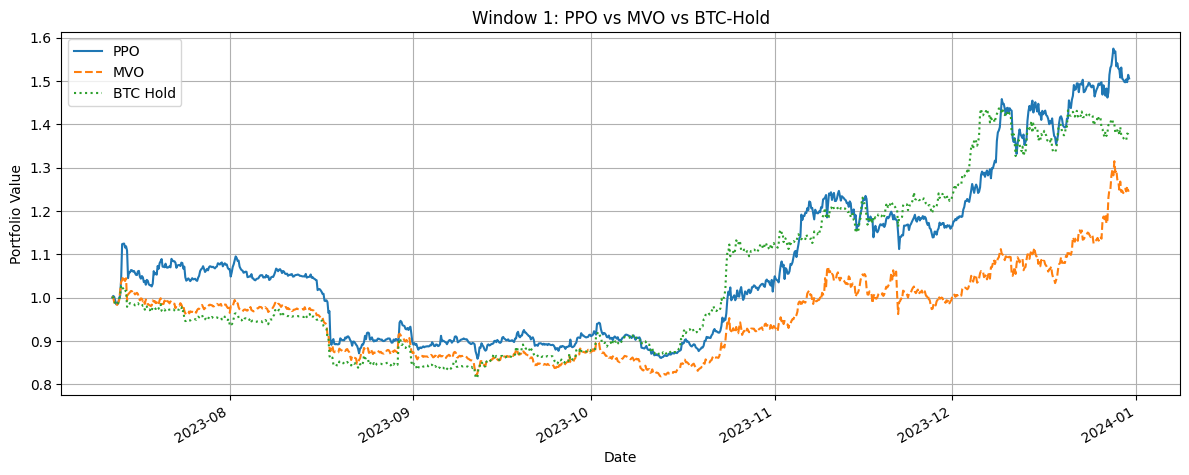

📈 Performance Summary (Window 1):
Strategy   |  Sharpe |   Max Drawdown
-----------------------------------
PPO        |    2.21 |        -45.46%
MVO        |    1.41 |        -37.76%
BTC Hold   |    2.09 |        -43.37%


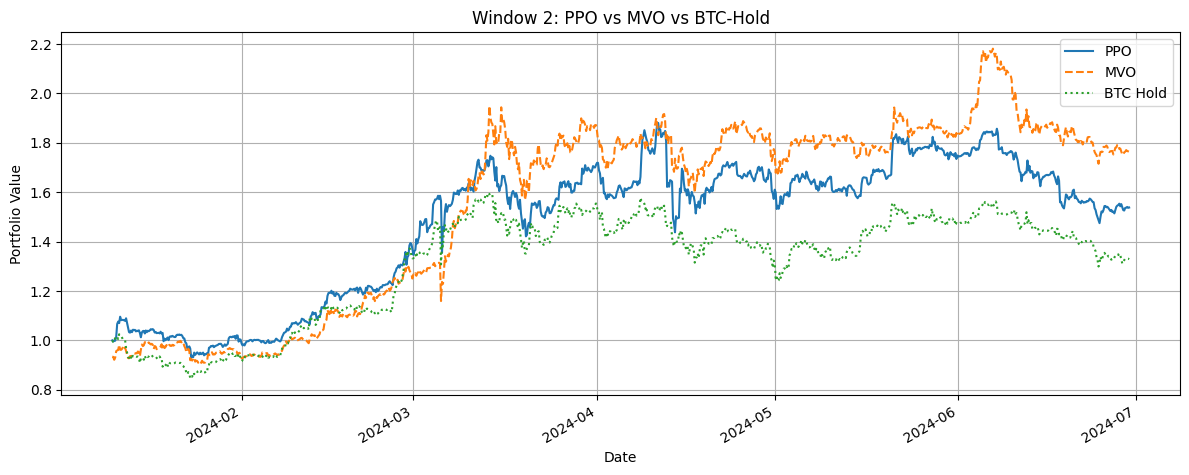

📈 Performance Summary (Window 2):
Strategy   |  Sharpe |   Max Drawdown
-----------------------------------
PPO        |    1.76 |        -50.56%
MVO        |    2.54 |        -58.50%
BTC Hold   |    1.42 |        -47.04%


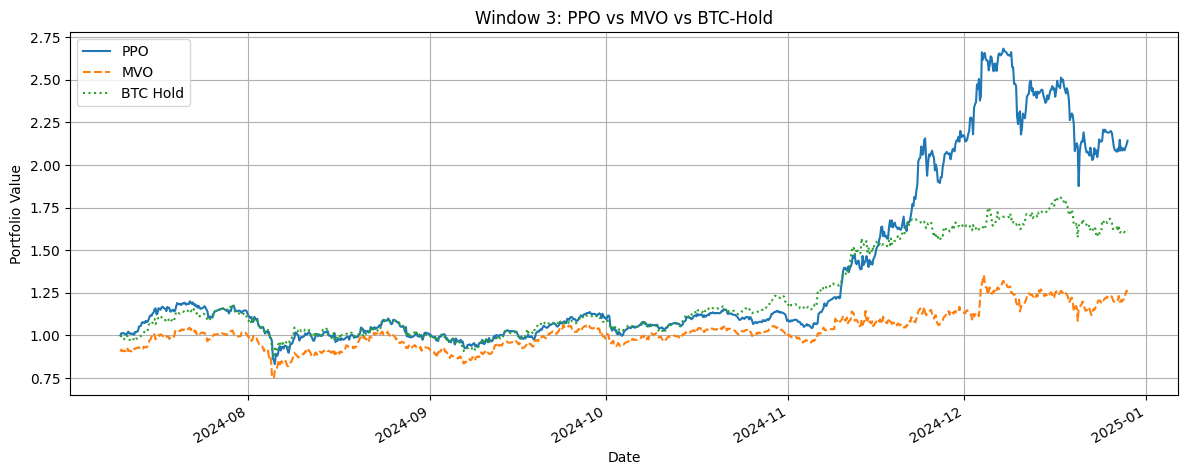

📈 Performance Summary (Window 3):
Strategy   |  Sharpe |   Max Drawdown
-----------------------------------
PPO        |    2.58 |        -68.99%
MVO        |    1.46 |        -44.72%
BTC Hold   |    2.25 |        -51.96%


In [13]:
for i in range(len(windows)):
    compare_strategies(window_idx=i, results=results, mvo_results=mvo_results, df_test_all=price_df, lookback=lookback_long)

## 5. Conclusions

- PPO-based DRL strategy consistently achieved higher Sharpe ratios than both MVO and BTC-hold baselines in 2 of 3 test windows.
- This supports the thesis that DRL agents trained with a Sharpe-based reward function can learn to manage portfolio risk dynamically.


### 🔁 Training Observations
- In all three evaluation windows, the PPO agent showed no signs of overfitting or policy collapse during the 8M-step training.
- The learning curves were stable and improved steadily across steps.
- Total training time (~13 minutes per window on an M3 Pro laptop) is efficient considering the quality of results. Further training (e.g., 16M+ steps) may yield higher Sharpe ratios and smoother allocations.

<p float="left">
  <img src="images/entropy_loss.png" width="30%" />
  <img src="images/explained_variance.png" width="30%" />
  <img src="images/value_loss.png" width="30%" />
</p>

### 📌 Suggestions for Further Improvements
- 💸 Incorporate trading fees:
Currently, the environment assumes frictionless rebalancing.
In practice, trading incurs commissions and slippage, especially in crypto markets.

- 📉 Risk-aware constraints: 
Introduce risk budgets, e.g., cap portfolio volatility or weight concentration: Limit max allocation to a single asset (e.g., ≤ 40%) Penalize high portfolio variance

- ⌛ Rebalance Frequency: The current setup rebalances every 4 hours; other frequencies (1h, 6h, 1d, etc.) can be explored.

- 🧠 Alternative Reward Designs: Differential Sharpe reward can be modified; one may penalize the drawdown and volatility. 